In [66]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ml_metrics import quadratic_weighted_kappa
import xgboost as xgb
import datetime as dt
import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
import functools
from sklearn.metrics import confusion_matrix
from scipy import optimize

data = pd.read_csv('data_imputed.csv')

### The following functions remained unchanged from the work in step 02:

In [55]:
def xg_eval_linear_pred(features, labels, test_features, test_labels, param, num_round, classify_function):
    
    features = np.asarray(features)
    labels = np.asarray(labels)
    
    test_features = np.asarray(test_features)
    test_labels = np.asarray(test_labels)
    

    xg_train = xgb.DMatrix(features, labels)
    xg_test = xgb.DMatrix(test_features, test_labels)

    bst = xgb.train(param, xg_train, num_round)
    
    train_prediction = classify_function(bst.predict(xg_train))
    test_prediction = classify_function(bst.predict(xg_test))
    
    return (bst,
            quadratic_weighted_kappa(labels,np.array(train_prediction)),
            quadratic_weighted_kappa(test_labels,np.array(test_prediction)), test_labels, test_prediction)


def make_plot_eval(y, yhat, text, kappa_text):
    fig,ax = plt.subplots(1,2, figsize=(9., 4.))
    
    y = pd.Series(y)
    yhat = pd.Series(yhat)

    yhist = y.value_counts()
    yhathist = yhat.value_counts()

    ax[0].scatter(yhist.index, yhist.values, s=40, c='blue', alpha=0.5, label='response')
    ax[0].scatter(yhathist.index-0.1, yhathist.values, s=40, c='green', alpha=0.5, label='prediction')
    
    ax[0].legend(loc='upper left', prop={'size':10})
    ax[0].set_xlabel('classification')
    ax[0].set_ylabel('frequency')
    
    
    
    ax[0].text(0.99, 1.01, text, fontsize=9,
            ha='right', va='bottom', transform=ax[0].transAxes)
    
    cm = confusion_matrix(y, yhat)
    print(cm)
    
    im = ax[1].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax[1].set_xlabel('true label')
    ax[1].set_ylabel('predicted label')    
    plt.colorbar(im)
    
    ax[1].text(0.99, 1.01, kappa_text, fontsize=12,
            ha='right', va='bottom', transform=ax[1].transAxes)

    fname = 'plots/classification_' + text.replace(':', '').replace(', ', '_').replace(' ','') + '.png'
    fig.savefig(fname, dpi=150)


def learning(data, eval_function, xgbparam, num_round, nsamples=[10000, 25000]):

    features = data[data['train?'] == True].drop(['train?', 'Id', 'Response'], axis=1)
    labels = data[data['train?'] == True]['Response'].astype('int') -1 
    
    text = "{} eta:{:0.2f}, max_depth:{:d},\nmin_child_weight:{:0.2f}, num_round:{:02d}".format(
        xgbparam['objective'],
        xgbparam['eta'], xgbparam['max_depth'], xgbparam['min_child_weight'], num_round)

    # Xtest, ytest will be saved for evaluating over a constant sized set:
    Xtrain, Xtest, ytrain, ytest = train_test_split(features, labels, train_size=0.70, random_state=17)


    # The number of samples taken out of X for training will be varied
    nsamples.append(len(Xtrain))

    results = []
    for n in nsamples:
        print("Working on n = {:05d}  at {:%H:%M:%S}".format(n, dt.datetime.now()))
        if n < len(Xtrain):
            Xsample, _, ysample, _ = train_test_split(Xtrain, ytrain, test_size=n, random_state=42)
        else:
            Xsample, ysample = Xtrain, ytrain
            
        model, train_qwk, test_qwk, y, yhat = eval_function(Xsample, ysample, Xtest, ytest, xgbparam, num_round)
        results.append([n, train_qwk, test_qwk])
        
        print("num categories = {:d}".format(len(np.unique(yhat))))
        
        print("train_qwk: {:0.4f}, test_qwk: {:0.4f}".format(train_qwk, test_qwk))
                          
        if n == len(Xtrain):
            kappa_text = '$\kappa_{{q,\mathrm{{train}}}} = {:0.4f}$, '.format(train_qwk) + \
            '$\kappa_{{q,\mathrm{{test}}}} = {:0.4f}$'.format(test_qwk)
            make_plot_eval(y, yhat, text, kappa_text)
    
    df = pd.DataFrame(results, columns=['num_samples', 'train_qwk', 'test_qwk'])
    
    if len(nsamples) > 1:
        make_plot_learning(df, text, num_round)
    
    return model, df


def make_plot_learning(df, text, num_round):
    fig,ax = plt.subplots(1,1)

    ax.scatter(df['num_samples'], df['train_qwk'], s=40, c='blue', alpha=0.5, label='train set')
    ax.scatter(df['num_samples'], df['test_qwk'], s=40, c='green', alpha=0.5, label='test set')
    
    ax.legend(loc='upper left', prop={'size':10})
    ax.set_xlabel('number of training samples')
    ax.set_ylabel('quadratic weighted kappa')
    

    ax.text(0.99, 1.01, text, fontsize=9,
            ha='right', va='bottom', transform=ax.transAxes)
    
    fname = 'plots/learning_' + text.replace(':', '').replace(', ', '_').replace(' ','') + '.png'
    fig.savefig(fname, dpi=150)


# In step 03, we will allow optimization of the score cuttofs used for classification

In step 02 we concluded that using a reg:linear objective for xgboost was a better choice for this problem than using the multi:softmax objective.  To obtain classification from an obtained score we simply rounded to the nearest integer in the range [0, 7]. In step 03 we will implement the possibility of varying the cutoffs used for classification.  

We will start out by defining a cutoff classifier that receives a list of 8 cutoffs.  When all of the numbers in the list are equal, our cutoff classifier should behave just like the nearest integer classifier:

In [49]:
def classify_with_cutoffs(predicted_score, cutoffs):
    
    predicted_score = np.asarray(predicted_score)
    cutoffs = np.asarray(cutoffs)
    
    # cutoffs are 8 numbers
    assert len(cutoffs) == 8
    
    min_score = -0.5
    max_score = 7.5
    ds = max_score - min_score
    
    total_cutoff_weight = sum(cutoffs)
    
    cut_points = [min_score]
    for cut in cutoffs:
        cut_points.append(cut_points[-1] + ds * cut/total_cutoff_weight)
    cut_points = cut_points[1:-1]
    
    clipped  = np.clip(predicted_score, -0.49, 7.49)
    predicted_class = np.digitize(clipped, cut_points).astype('int')
    
    return predicted_class



cutoffs = [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]


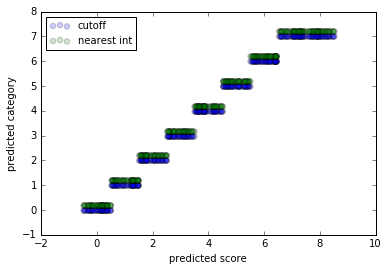

In [54]:
se = pd.Series(np.random.rand(500)*9 - 0.5, name='random')

cutoffs = [10.] * 8
print("\ncutoffs = {}".format(cutoffs))
classes = pd.Series(classify_with_cutoffs(se, cutoffs))
nearest_int_classes = np.rint(np.clip(se, -0.49, 7.49))

np.testing.assert_array_equal(classes, nearest_int_classes)
                    
fig, ax = plt.subplots(1,1)
ax.scatter(se, classes, s=30, c='blue', alpha=0.2, label='cutoff')
ax.scatter(se, nearest_int_classes + 0.2, s=30, c='green', alpha=0.2, label='nearest int')

ax.legend(loc='upper left', prop={'size':10})
ax.set_xlabel('predicted score')
ax.set_ylabel('predicted category')

### We now will proceed to define a way to learn what the best cutoffs are for a given training set.   

To get started we split the data into training samples and validation set and fit a model.  From the model we obtain the xgboost scores for the training samples and the test set

To test the cutoff learning we fit a model and use nearest int to classify: 

[[  10  227  377  440  404  333   98    0]
 [   3  243  392  474  419  308   96    0]
 [   0   19  188   66   28   12    8    0]
 [   0    6  198  149   27   33   30    0]
 [   0   17  222  724  439  170   45    0]
 [   0   11  153  538 1411  979  206    0]
 [   0    0   11  188  801 1051  408    0]
 [   0    0    1   33  393 2220 3206    0]]


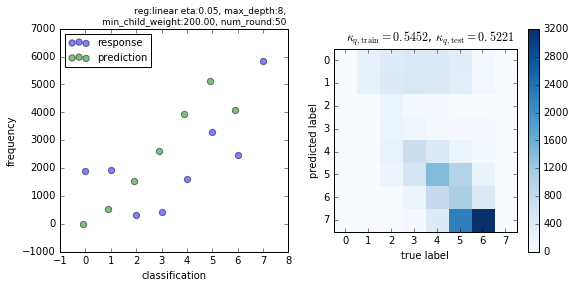

In [151]:
# xgboost parameters:
param = {}

# use softmax multi-class classification
param['objective'] = 'reg:linear'

param['eta'] = 0.05
param['max_depth'] = 8
param['min_child_weight'] = 200

param['silent'] = 1
param['nthread'] = 1


def classify(prediction):
    return np.rint(np.clip(prediction, -0.49, 7.49))


features = data[data['train?'] == True].drop(['train?', 'Id', 'Response'], axis=1)
labels = data[data['train?'] == True]['Response'].astype('int') -1 

text = "{} eta:{:0.2f}, max_depth:{:d},\nmin_child_weight:{:0.2f}, num_round:{:02d}".format(
    param['objective'],
    param['eta'], param['max_depth'], param['min_child_weight'], num_round)

# Xtest, ytest will be saved for evaluating over a constant sized set:
Xtrain, Xtest, ytrain, ytest = train_test_split(features, labels, train_size=0.70, random_state=17)


Xsample, ysample = Xtrain, ytrain

num_round = 50
eval_function = functools.partial(xg_eval_linear_pred, classify_function=classify)
model, train_qwk, test_qwk, y, yhat = eval_function(Xsample, ysample, Xtest, ytest, param, num_round)

xg_sample = xgb.DMatrix(Xsample, ysample)
xg_test = xgb.DMatrix(Xtest, ytest)

ysamsple_score = model.predict(xg_sample)
ytest_score = model.predict(xg_test)



kappa_text = '$\kappa_{{q,\mathrm{{train}}}} = {:0.4f}$, '.format(train_qwk) + \
'$\kappa_{{q,\mathrm{{test}}}} = {:0.4f}$'.format(test_qwk)
make_plot_eval(y, yhat, text, kappa_text)


We now define the procedure to learn the cutoffs:

In [152]:
def learn_cutoffs(predicted_score, labels, *, verbose=False):
    
    predicted_score = np.asarray(predicted_score, dtype=np.float64)
    labels = np.asarray(labels, dtype=np.float64)
    
    
    start_cutoffs = [10.]*8
    
    def error_function(p, x, y):
        return classify_with_cutoffs(x, p).astype(np.float64) - y 
    
    just = 15
    if verbose:
        print("{} : {}".format(
                "start error".rjust(just),
                np.std(error_function(start_cutoffs, predicted_score, labels))))
    
    
    pfit, pcov, infodict, errmsg, success = \
        optimize.leastsq(error_function, start_cutoffs,
                         args=(predicted_score, labels), full_output=1, epsfcn=1.0)
        
    if verbose:
        prec = np.get_printoptions()['precision']
        np.set_printoptions(precision=4)
        print("{} : {}".format("num func eval".rjust(just), infodict['nfev']))
        print("{} : {}".format("pfit".rjust(just), pfit))
        np.set_printoptions(prec)
    
    if verbose:
        print("{} : {}\n".format(
                "final error".rjust(just),
                np.std(error_function(pfit, predicted_score, labels))))
        
        
    return pfit

We use the learning procedure to obtain classifications for both the training and testing sets:

    start error : 1.882953645303364
  num func eval : 63
           pfit : [ 17.6735  12.0431  10.4977  10.1132  10.269    9.3909  11.5362  20.9923]
    final error : 1.8645676465010819

[[  60  285  322  357  336  275  229   25]
 [  37  327  328  385  354  267  215   22]
 [   0   58  156   57   24   11   14    1]
 [   0   16  229   95   35   21   40    7]
 [   1   57  243  580  450  154  126    6]
 [   0   37  160  434 1001 1074  565   27]
 [   0    1   14  147  546  791  894   66]
 [   0    0    1   24  193  837 3621 1177]]


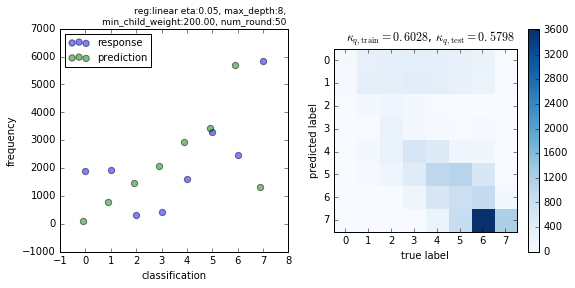

In [153]:
best_cutoffs = learn_cutoffs(ysamsple_score, ysample, verbose=True)

ytrain_cutoffs = classify_with_cutoffs(ysamsple_score, best_cutoffs)
ytest_cutoffs = classify_with_cutoffs(ytest_score, best_cutoffs)

train_cutoffs_qwk = quadratic_weighted_kappa(np.asarray(ysample), ytrain_cutoffs)
test_cutoffs_qwk = quadratic_weighted_kappa(np.asarray(ytest), ytest_cutoffs)

kappa_text = '$\kappa_{{q,\mathrm{{train}}}} = {:0.4f}$, '.format(train_cutoffs_qwk) + \
'$\kappa_{{q,\mathrm{{test}}}} = {:0.4f}$'.format(test_cutoffs_qwk)
make_plot_eval(y, ytest_cutoffs, text, kappa_text)

## Success,  the quadratic weighted kappa for both the training and testing sets went up consisderably!

Below we show a plot of waht the cutoffs did with our scored data.   

In this case notice that the upper end of the range of predicted scores is not that high, only goes up right above 6.  This has to do with the fact that we used only 50 boosting rounds to train this model.  

We should now try the cutoff optimization for a model with a larger number of boosting rounds. 

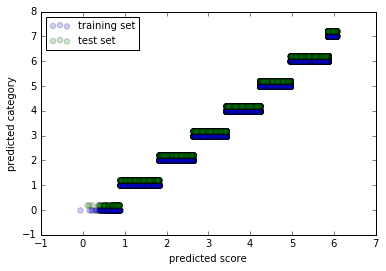

In [154]:
fig, ax = plt.subplots(1,1)
ax.scatter(ysamsple_score, ytrain_cutoffs, s=30, c='blue', alpha=0.2, label='training set')
ax.scatter(ytest_score, ytest_cutoffs + 0.2, s=30, c='green', alpha=0.2, label='test set')

ax.legend(loc='upper left', prop={'size':10})
ax.set_xlabel('predicted score')
ax.set_ylabel('predicted category')

# We define a function to fit and evaluate a model, incorporating the cutoff optimization step:

In [155]:
def xg_eval_linear_cuts_pred(features, labels, test_features, test_labels, param, num_round):
    
    features = np.asarray(features)
    labels = np.asarray(labels)
    
    test_features = np.asarray(test_features)
    test_labels = np.asarray(test_labels)
    

    xg_train = xgb.DMatrix(features, labels)
    xg_test = xgb.DMatrix(test_features, test_labels)

    bst = xgb.train(param, xg_train, num_round)
    
    # Here we learn the best cuttofs:
    best_cutoffs = learn_cutoffs(bst.predict(xg_train), labels)
    
    # Classification is done with the best cuttofs
    train_prediction = classify_with_cutoffs(bst.predict(xg_train), best_cutoffs)
    test_prediction = classify_with_cutoffs(bst.predict(xg_test), best_cutoffs)
    
    return (bst, best_cutoffs,
            quadratic_weighted_kappa(labels,np.array(train_prediction)),
            quadratic_weighted_kappa(test_labels,np.array(test_prediction)), test_labels, test_prediction)


We go ahead and train a model with 150 rounds:

[[ 115  327  295  335  305  285  188   39]
 [  54  333  343  387  347  276  156   39]
 [   4   83  137   54   15   15   10    3]
 [   2   29  188  137   17   22   31   17]
 [   2   61  219  529  493  184  114   15]
 [   3   44  169  414  899 1168  512   89]
 [   0    4   25  129  443  859  775  224]
 [   0    0    4   41  185  886 2572 2165]]


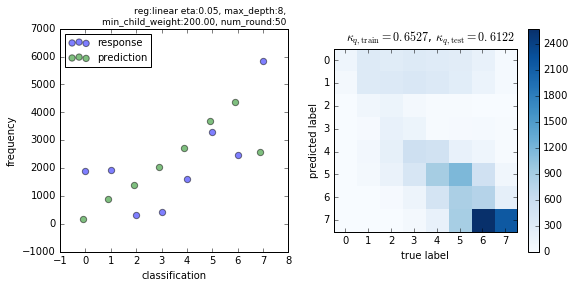

In [158]:
# xgboost parameters:
param = {}

# use softmax multi-class classification
param['objective'] = 'reg:linear'

param['eta'] = 0.05
param['max_depth'] = 8
param['min_child_weight'] = 200

param['silent'] = 1
param['nthread'] = 1


features = data[data['train?'] == True].drop(['train?', 'Id', 'Response'], axis=1)
labels = data[data['train?'] == True]['Response'].astype('int') -1 

text = "{} eta:{:0.2f}, max_depth:{:d},\nmin_child_weight:{:0.2f}, num_round:{:02d}".format(
    param['objective'],
    param['eta'], param['max_depth'], param['min_child_weight'], num_round)

# Xtest, ytest will be saved for evaluating over a constant sized set:
Xtrain, Xtest, ytrain, ytest = train_test_split(features, labels, train_size=0.70, random_state=17)


Xsample, ysample = Xtrain, ytrain

num_round = 150
model, best_cutoffs, train_qwk, test_qwk, y, yhat = xg_eval_linear_cuts_pred(Xsample, ysample, Xtest, ytest, param, num_round)


kappa_text = '$\kappa_{{q,\mathrm{{train}}}} = {:0.4f}$, '.format(train_qwk) + \
'$\kappa_{{q,\mathrm{{test}}}} = {:0.4f}$'.format(test_qwk)
make_plot_eval(y, yhat, text, kappa_text)

In [159]:
best_cutoffs

array([ 13.5673,  13.2133,   9.9518,  10.4772,   9.9239,  10.6484,
        10.0627,  13.9127])

## Submission:

In [160]:
data = pd.read_csv('data_imputed.csv')

features = data[data['train?'] == True].drop(['train?', 'Id', 'Response'], axis=1)
labels = data[data['train?'] == True]['Response'].astype('int') -1 
submission_features = data[data['train?'] == False].drop(['train?', 'Id', 'Response'], axis=1)


xg_submission = xgb.DMatrix(submission_features)
submission_prediction = model.predict(xg_submission)
submission = classify_with_cutoffs(submission_prediction, best_cutoffs)

submission_ids = data[data['train?'] == False]['Id']
submission_df = pd.DataFrame({"Id": submission_ids, "Response": submission.astype('int') + 1})
submission_df = submission_df.set_index('Id')
submission_df.to_csv('step03_submission.csv')

submission_df.describe()


,Response
count,19765.000000
mean,5.650696
std,1.750624
min,1.000000
25%,4.000000
50%,6.000000
75%,7.000000
max,8.000000


Let's check and see how many entries are different in the submissions from step 02 and step 03:

In [161]:
df02 = pd.read_csv('step02_submission.csv')
df03 = pd.read_csv('step03_submission.csv')

diff = pd.Series(df03['Response'].values - df02['Response'].values, name="03-02")

In [163]:
print(len(diff))
print(sum(diff>0))
print(sum(diff<0))

19765
2460
1869


So in step03 we increased the category of 2460 observations and decreased the category of 1869 observations.  

As it is shown below, the mean value of the categories where we increased the classification was 6.15 , and the mean value of the categories where we decreased the classification was 4.55.  

In [166]:
df02[diff > 0]['Response'].describe()

count    2460.000000
mean        6.157724
std         1.202005
min         1.000000
25%         6.000000
50%         7.000000
75%         7.000000
max         7.000000
Name: Response, dtype: float64

In [167]:
df02[diff < 0]['Response'].describe()

count    1869.000000
mean        4.551097
std         1.305230
min         2.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         8.000000
Name: Response, dtype: float64